# General Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

print("Libraries imported")

Libraries imported


# Download starting dataset

In [2]:
training_set = yf.download('AAPL', start='2010-01-01', end='2020-01-01')
training_set = training_set[['Close']]
training_set['Change'] = training_set['Close'].pct_change()
training_set = training_set.dropna()
print(training_set.head())

test_set = yf.download('AAPL', start='2020-01-01', end='2024-01-01')
test_set = test_set[['Close']]
test_set['Change'] = test_set['Close'].pct_change()
test_set = test_set.dropna()
print(test_set.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price          Close    Change
Ticker          AAPL          
Date                          
2010-01-05  6.451467  0.001729
2010-01-06  6.348846 -0.015906
2010-01-07  6.337108 -0.001849
2010-01-08  6.379241  0.006649
2010-01-11  6.322965 -0.008822


[*********************100%***********************]  1 of 1 completed

Price           Close    Change
Ticker           AAPL          
Date                           
2020-01-03  72.009102 -0.009723
2020-01-06  72.582909  0.007969
2020-01-07  72.241547 -0.004703
2020-01-08  73.403641  0.016086
2020-01-09  74.962807  0.021241


## Some starting visualisation

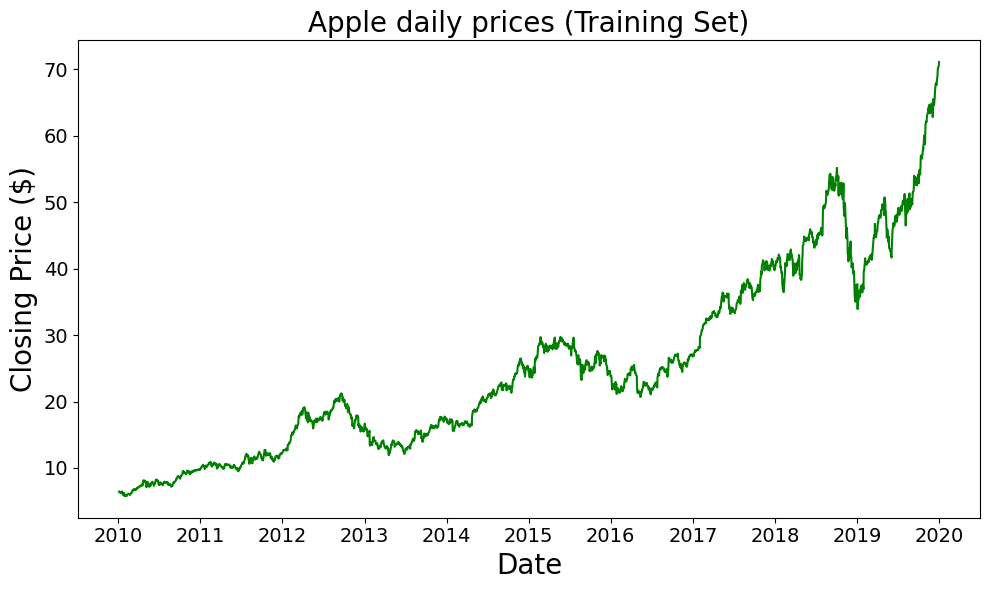

In [3]:
plt.figure(figsize=(10,6))
plt.plot(
  training_set.index,
  training_set['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()

Main Statitics:


count    2515.000000
mean        0.001087
std         0.016220
min        -0.123558
25%        -0.006749
50%         0.000944
75%         0.009820
max         0.088741
Name: Change, dtype: float64

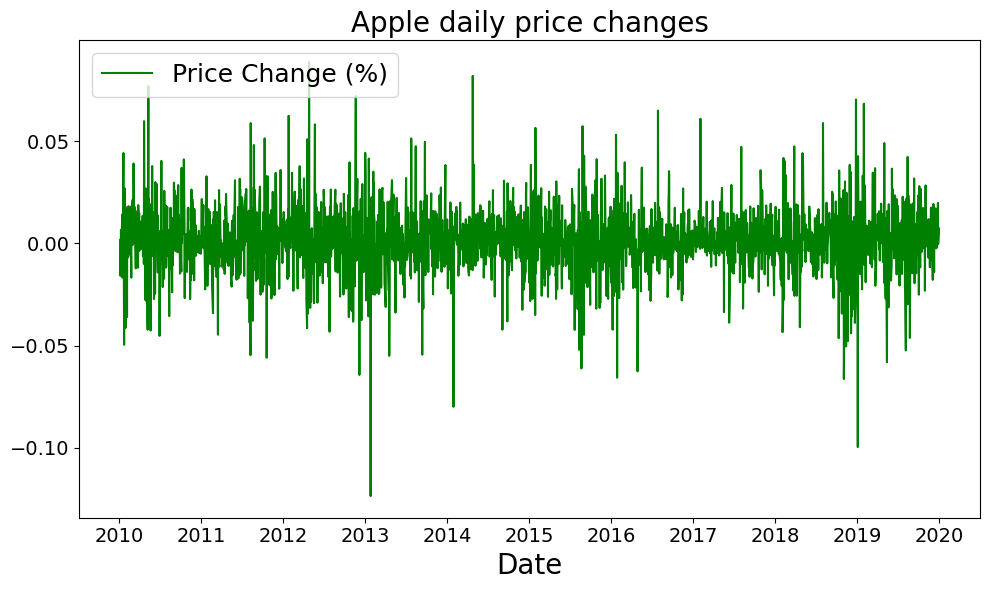

In [ ]:
plt.figure(figsize=(10,6))
fig, ax = plt.subplots(2,1,figsize=(12, 8))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=18, loc="upper left")

sns.lineplot(x=training_set.index, y=training_set['Change'], label='Change (%)', ax=ax[0])
sns.histplot(training_set['Change'], bins=30, kde=True, ax=ax[1])

plt.tight_layout()
print("Main Statitics:")
training_set['Change'].describe()

As seen from the statistics above, stock prices can fluctuate greatly, and in the case of Apple, daily change has a standard deviation of 1.6%, while having a mean of 0.1%. This showcases the main problem of stock price prediction: trying to find patterns in a stochastic system, which has so much noise, that there is hardly any system to it. In real life, models are retrained frequently, because of the constant change of the market.

# Fitting Linear Regression model on RSI Indicator

In [ ]:
training_linreg = training_set.copy(deep=True)

rsi_columns = []
for i in range(2, 25):
  rsi = talib.RSI(training_linreg['Close'].values, timeperiod=i) #Don't forget to ravel the numpy array
  training_linreg[f'RSI_{i}'] = rsi
  rsi_columns.append(f'RSI_{i}')

training_linreg = training_linreg.dropna()
print(training_linreg.head())

Price          Close    Change      RSI_2      RSI_3      RSI_4      RSI_5  \
Ticker          AAPL                                                         
Date                                                                         
2010-02-09  5.904063  0.010663  65.970661  55.285889  50.264657  47.425754   
2010-02-10  5.871863 -0.005454  45.860935  46.689185  45.251039  43.990116   
2010-02-11  5.978696  0.018194  82.089137  69.946179  62.012529  56.929829   
2010-02-12  6.030154  0.008607  89.109508  77.148731  68.254289  62.189185   
2010-02-16  6.121038  0.015072  95.432917  86.022977  77.110980  70.218104   

Price           RSI_6      RSI_7      RSI_8      RSI_9  ...     RSI_15  \
Ticker                                                  ...              
Date                                                    ...              
2010-02-09  45.611339  44.415819  43.541238  42.796702  ...  41.145928   
2010-02-10  43.019555  42.332792  41.794155  41.290341  ...  40.313001   
2010-

In [69]:
pca = PCA() # We will use PCA to reduce the number of features
pca_data = pca.fit_transform(training_linreg[rsi_columns])
lookback = 6 # We will use the last 6 days to predict the next day

# Least Squares Regression
model = LinearRegression()
X = pca_data[:-lookback]
y = training_linreg['Change'].shift(-lookback)[:-lookback] # We shift the data by lookback days to predict the future
model.fit(X, y)

# Predicting the training set
pred = model.predict(pca_data)
pred = pred[lookback-1:-lookback]
# Aligning the dates of prediction with dates from the training set
pred_dates = training_linreg.index[lookback-1:len(training_linreg)-lookback]

In [70]:
# Debugging
print(training_linreg.index[lookback-1:len(training_linreg)-lookback])
print(f"Length of pred_dates: {len(pred_dates)}")
print(f"Length of pred: {len(pred)}")

DatetimeIndex(['2010-02-17', '2010-02-18', '2010-02-19', '2010-02-22',
               '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26',
               '2010-03-01', '2010-03-02',
               ...
               '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12',
               '2019-12-13', '2019-12-16', '2019-12-17', '2019-12-18',
               '2019-12-19', '2019-12-20'],
              dtype='datetime64[ns]', name='Date', length=2480, freq=None)
Length of pred_dates: 2480
Length of pred: 2480


In [83]:
# Store predicitons and signals in DataFrame
predictions_df = pd.DataFrame({'Date': pred_dates, 'Prediction': pred})

# Thresholds
long_threshold = np.quantile(pred,0.6)
short_threshold = np.quantile(pred,0.1)

predictions_df['Signal'] = 0
predictions_df.loc[predictions_df['Prediction'] > long_threshold, 'Signal'] = 1 # Buy if the prediction is above the 90th percentile
predictions_df.loc[predictions_df['Prediction'] < short_threshold, 'Signal'] = -1 # Short if the prediction is below the 10th percentile

# Aligning signals with daily returns
aligned_signals = predictions_df.set_index('Date')['Signal'].reindex(training_linreg.index).fillna(0).shift(1)
investment_returns = training_linreg['Change'] * aligned_signals
investment_returns.fillna(0, inplace=True)

In [84]:
# Calculate final investment value
investment = 1000
final_investment = investment * (1 + investment_returns).cumprod().iloc[-1]

print(f"Final investment value with ${investment} start: {final_investment}")

# Returns with our strategy
cumulative_returns = (1 + investment_returns).cumprod() -1
# Returns with buy and hold strategy for comparison
aapl_cumulative_returns = (1 +training_linreg['Close'].pct_change()).cumprod() -1



Final investment value with $1000 start: 2063.0743721527156


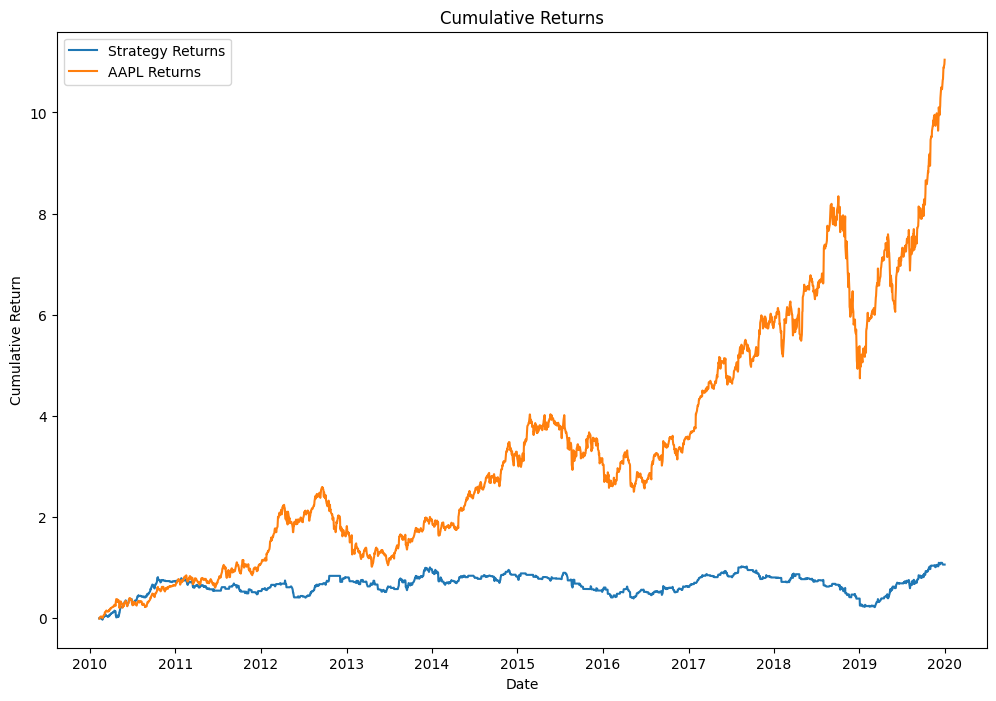

RSI strategy returns: 1.0630743721527156
Buy and hold returns: Ticker
AAPL    11.04153
Name: 2019-12-31 00:00:00, dtype: float64


In [85]:
# Plot Results
plt.figure(figsize=(12,8))
plt.plot(cumulative_returns, label='Strategy Returns')
plt.plot(aapl_cumulative_returns, label='AAPL Returns')
plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
print(f"RSI strategy returns: {cumulative_returns.iloc[-1]}")
print(f"Buy and hold returns: {aapl_cumulative_returns.iloc[-1]}")



## Interpretation
While the strategy is obviously bad, it should be noted that at no point did we go into the negative with our investments. This shows that the strategy predicts correctly more often than not, however the gains with each trade are miniscule. This can be attributed to two things: Currently, shorting is allowed, which is a risky strategy, and a series of bad shorts resulted in losing some of our gains from 2016 to 2019. Secondly, the strategy holds only for small amounts of time, which reduces the potential earnings to sub 1%, since usually a trade is only held for a couple of days. This is a double edged sword, since we reduce both gains and losses.

# Fitting Linear Regression on test set

Final investment value with $1000 start: 857.3771454736457


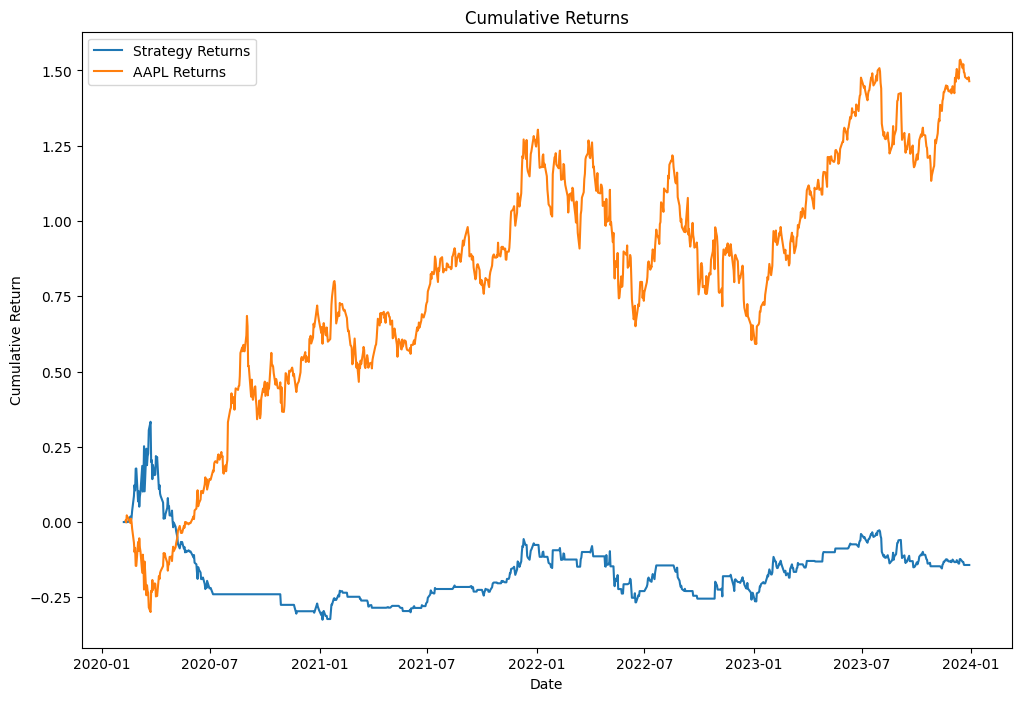

RSI strategy returns: -0.14262285452635437
Buy and hold returns: Ticker
AAPL    1.464199
Name: 2023-12-29 00:00:00, dtype: float64


In [89]:
test_linreg = test_set.copy(deep=True)

rsi_columns = []
for i in range(2, 25):
  rsi = talib.RSI(test_linreg['Close'].to_numpy().ravel(), timeperiod=i) #Don't forget to ravel the numpy array
  test_linreg[f'RSI_{i}'] = rsi
  rsi_columns.append(f'RSI_{i}')

test_linreg = test_linreg.dropna()
#test_linreg = test_linreg[25:]

pca_data_test = pca.transform(test_linreg[rsi_columns])

# Predictions for the test data
pred_test = model.predict(pca_data_test)
pred_test = pred_test[lookback-1:-lookback]

# Align the index for predictions with the corresponding dates of the original data
pred_dates_test = test_linreg.index[lookback-1:len(test_linreg.index)-lookback] #Adjusted to align with X and y

# Store predictions and signals in a dataframe
predictions_test_df = pd.DataFrame({'Date': pred_dates_test, 'Prediction': pred_test})

# Thresholds

long_thresh_test = np.quantile(pred_test, 0.6)
short_thresh_test = np.quantile(pred_test, 0.1)

predictions_test_df['Signal'] = 0
predictions_test_df.loc[predictions_test_df['Prediction'] > long_thresh_test, 'Signal'] = 1
predictions_test_df.loc[predictions_test_df['Prediction'] < short_thresh_test, 'Signal'] = -1

# Aligning signals with daily returns
aligned_signals_test = predictions_test_df.set_index('Date')['Signal'].reindex(test_linreg.index).fillna(0).shift(1) #Shift signals
investment_returns_test = test_linreg['Change'] * aligned_signals_test

# Fill NaN values in with 0
investment_returns_test.fillna(0, inplace=True)

# Calculate final investment value
investment_test = 1000
final_investment_test = investment_test * (1 + investment_returns_test).cumprod().iloc[-1]

print(f"Final investment value with ${investment_test} start: {final_investment_test}")

cumulative_returns_test  = (1 + investment_returns_test).cumprod() -1

# Calculate AAPL's cumulative returns for comparison
aapl_cumulative_returns_test = (1 +test_linreg['Close'].pct_change()).cumprod() -1

# Plot Results
plt.figure(figsize=(12,8))
plt.plot(cumulative_returns_test, label='Strategy Returns')
plt.plot(aapl_cumulative_returns_test, label='AAPL Returns')
plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
print(f"RSI strategy returns: {cumulative_returns_test.iloc[-1]}")
print(f"Buy and hold returns: {aapl_cumulative_returns_test.iloc[-1]}")

## Conclusion

The strategy is not only useless, it is actively losing money. Not surprising of course, if stock markets could be hacked with a simple linear regression, everyone would be a millionaire. Still, it's good for showcasing how much better other models perform, if for nothing else.

Of course you could play around with what parameters should be given to the model and whatnot, but linear regression still won't produce impressive results.